# <font color='blue'>Using Deep Learning to detect fraud in credit card transactions</font>

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project.

It contains credit cards transactions occured during two days of September 2013. It is a highly unbalanced dataset, and most variables have been anonimized and transformed using PCA. "Time" and "Amount" however haven't been transformed.

The objective here is to identify fraudulent credit card transactions. The metric used should be the Area Under the Precision-Recall Curve (AUPRC).

Some variable descriptions:
- 'Time' expresses the time in seconds elapsed between each transaction and the first transaction in the dataset. 
- 'Amount' is the transaction amount, this feature can be used for example-dependant cost-senstive learning.
- 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


# Takeaways

In this notebook we explored how deep learning can be used to predict fraudulent transactions. There are several different frameworks which can be used, and here we utilize Keras, which uses Tensorflow as a backend, to build our model with different number of layers.

We also practiced handling unbalanced data using `pandas_ml`, transforming features into components using `PCA` from `scikit-learn` and tuning Keras hyperparameters. Moreover, we used `pandas_ml` instead of `scikit-learn` to analyze our results.

References:

https://www.kaggle.com/mlg-ulb/creditcardfraud

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

In [1]:
# Loading packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('input/creditcard.csv')
X = df.iloc[:,:-1]
y = df['Class']
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Non fraud 0: 284315 (99.83%)
Fraud 1: 492 (0.17%)


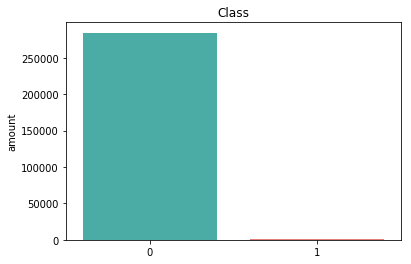

In [3]:
# Function to check the output variable
def check_output(dataset, output):
    amount = dataset[output].value_counts()
    ratio =  dataset[output].value_counts(normalize = True)*100
    print('Non fraud 0: {} ({}%)'.format(amount[0], round(ratio[0],2)))
    print('Fraud 1: {} ({}%)'.format(amount[1], round(ratio[1],2)))

    labels = ['1' if label == 1 else '0' for label in dataset[output]]
    palette = {'1': '#f56b69', '0': '#3bbbb3'}

    ax = sns.countplot(labels, palette = palette)
    plt.title(output)
    plt.ylabel('amount')
    return plt.show()

check_output(df, 'Class')

# Model 1 - single neural network 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print(X_train.shape)

(190820, 30)


In [5]:
# Keras e TensorFlow
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(30, input_dim = X_train.shape[1], activation = 'relu'))     
model.add(Dense(1, activation = 'sigmoid'))                
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(X_train.as_matrix(), y_train, epochs = 1)

Epoch 1/1
190820/190820 [==============================] - 10s 51us/step - loss: 0.3427 - acc: 0.9785


Loss/Accuracy:  [0.025553365930263618, 0.9984146743698596]
Average precision-recall score: 0.00
AUC: 0.50

Confusion matrix:

 Predicted      0  1  __all__
Actual                      
0          93838  0    93838
1            149  0      149
__all__    93987  0    93987


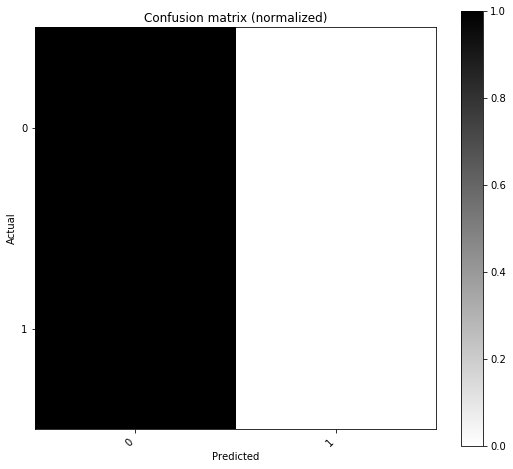

Confusion Matrix:

Predicted      0  1  __all__
Actual                      
0          93838  0    93838
1            149  0      149
__all__    93987  0    93987


Overall Statistics:

Accuracy: 0.9984146743698596
95% CI: (0.9981389650810484, 0.9986588455019066)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         0           1
Population                                  93987       93987
P: Condition positive                       93838         149
N: Condition negative                         149       93838
Test outcome positive                       93987           0
Test outcome negative                           0       93987
TP: True Positive                           93838           0
TN: True Negative                               0       93838
FP: False Positive                            149           0
FN: False Negative                              0         149
TPR

In [7]:
from pandas_ml import ConfusionMatrix
from sklearn.metrics import average_precision_score, roc_auc_score

print("Loss/Accuracy: ", model.evaluate(X_test.as_matrix(), y_test, verbose = 0))

# Predicting frauds in the test dataset
y_predicted = model.predict(X_test.as_matrix()).T[0].astype(int)

average_precision = average_precision_score(y_test, y_predicted)
roc_auc = roc_auc_score(y_test, y_predicted)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('AUC: {0:0.2f}'.format(roc_auc))


# Plotting a confusion matrix
y_true = np.array(y_test)
confusion_matrix = ConfusionMatrix(y_true, y_predicted)
print("\nConfusion matrix:\n\n {}" .format(confusion_matrix))
confusion_matrix.plot(normalized = True)
plt.show()
confusion_matrix.print_stats()

A single neural network yields an accuracy of 99%. But when we look at the confusion matrix, we can conclude that the model is not predicting the class correctly.

# Model 2 - Applying scale, oversampling and PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pandas_ml as pdml


## Oversampling #################################
# Creating a ModelFrame to be able to oversample
df2 = pdml.ModelFrame(X, target = y)
# Set the type of imbalance treatment we wish to apply
sampler = df2.imbalance.over_sampling.SMOTE()
# Fit the sample to obtain the 'balanced' dataset
oversampled = df2.fit_sample(sampler)

print('After oversampling, we have {} registers that are fraud and {} registers that are ok.'
      .format(oversampled['Class'].value_counts()[1],
              oversampled['Class'].value_counts()[0]))
# Split features and target
new_X, new_y = oversampled.iloc[:,:-1], oversampled['Class']

## Scale ########################################
# Scale the features
data = scale(new_X)

## PCA ##########################################
# Applying PCA to the scaled data, setting number of components to 10
pca = PCA(n_components = 10)
new_X = pca.fit_transform(data)
print('\nAfter scaling and applying PCA, our dataset has been reduced to 10 variables.')

After oversampling, we have 284315 registers that are fraud and 284315 registers that are ok.

After scaling and applying PCA, our dataset has been reduced to 10 variables.


In [9]:
X2_train, X2_test, y2_train, y2_test = train_test_split(new_X, new_y.as_matrix(), test_size = 0.33, random_state = 42)

model2 = Sequential()
model2.add(Dense(10, input_dim = 10, activation = 'relu'))     
model2.add(Dense(1, activation = 'sigmoid'))                
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [10]:
model2.fit(X2_train, y2_train, epochs = 1)

Epoch 1/1
380982/380982 [==============================] - 19s 51us/step - loss: 0.0409 - acc: 0.9860


Loss/Accuracy:  [0.016149484859122657, 0.9953263557298773]
Average precision-recall score: 0.77
AUC: 0.77

Confusion matrix:

 Predicted   False   True  __all__
Actual                           
False       93759     16    93775
True        43734  50139    93873
__all__    137493  50155   187648


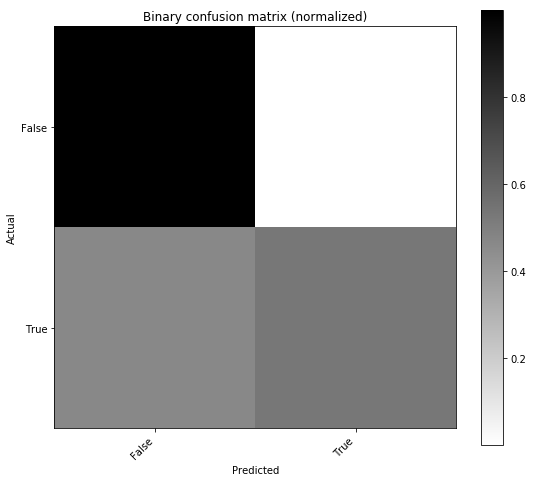

In [11]:
# Evaluate model
print("Loss/Accuracy: ", model2.evaluate(X2_test, y2_test, verbose = 0))

# Predicting frauds in the test dataset
y2_predicted = model2.predict(X2_test).T[0].astype(int)

# Calculates precision-recall score and auc
average_precision2 = average_precision_score(y2_test, y2_predicted)
roc_auc2 = roc_auc_score(y2_test, y2_predicted)
print('Average precision-recall score: {0:0.2f}'.format(average_precision2))
print('AUC: {0:0.2f}'.format(roc_auc2))


# Plotting a confusion matrix
y2_true = np.array(y2_test)
confusion_matrix2 = ConfusionMatrix(y2_true, y2_predicted)
print("\nConfusion matrix:\n\n {}" .format(confusion_matrix2))
confusion_matrix2.plot(normalized = True)
plt.show()

# Model 3 - Increasing the number of hidden layers in our neural network and changing some parameters

In [12]:
X3_train, X3_test, y3_train, y3_test = train_test_split(new_X, new_y.as_matrix(), test_size = 0.33, random_state = 42)

model3 = Sequential()
model3.add(Dense(10, input_dim = 10, activation = 'tanh')) 
model3.add(Dense(27, activation = 'tanh'))
model3.add(Dense(16, activation = 'tanh'))
model3.add(Dense(2, activation = 'tanh'))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 27)                297       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                448       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 892
Trainable params: 892
Non-trainable params: 0
_________________________________________________________________


In [13]:
model3.fit(X3_train, y3_train, epochs = 2)

Epoch 1/2
380982/380982 [==============================] - 22s 58us/step - loss: 0.0337 - acc: 0.9933
Epoch 2/2
380982/380982 [==============================] - 22s 57us/step - loss: 0.0090 - acc: 0.9968


In [14]:
print("Loss: ", model3.evaluate(X3_test, y3_test, verbose = 0))

y3_predicted = np.round(model3.predict(X3_test)).T[0]
y3_correct = np.array(y3_test)

# Calculates precision-recall score and auc
average_precision3 = average_precision_score(y3_correct, y3_predicted)
roc_auc3 = roc_auc_score(y2_test, y2_predicted)

print('Average precision-recall score: {0:0.2f}'.format(average_precision3))
print('AUC: {0:0.2f}'.format(roc_auc3))

Loss:  [0.00791868054244211, 0.9973354365620737]
Average precision-recall score: 1.00
AUC: 0.77


In [15]:
FN = 0
FP = 0
incorrect = 0
total = len(y3_test)
for i in range(len(y3_test)):
    if y3_predicted[i] != y3_correct[i]:
        incorrect += 1
        if y3_correct[i] == 1 and y3_predicted[i] == 0:
            FN += 1
        else:
            FP += 1

inaccuracy = incorrect / total

print('Incorrect:', incorrect)
print('Inaccuracy:', inaccuracy)
print('Accuracy:', 1 - inaccuracy)
print('False Negatives ratio:', FN/incorrect)
print('False Positives ratio:', FP/ incorrect )
print('False Negatives/total:', FN/total)

Incorrect: 500
Inaccuracy: 0.00266456343792633
Accuracy: 0.9973354365620737
False Negatives ratio: 0.334
False Positives ratio: 0.666
False Negatives/total: 0.0008899641882673942


Confusion matrix: 

Predicted  False   True  __all__
Actual                          
False      93442    333    93775
True         167  93706    93873
__all__    93609  94039   187648


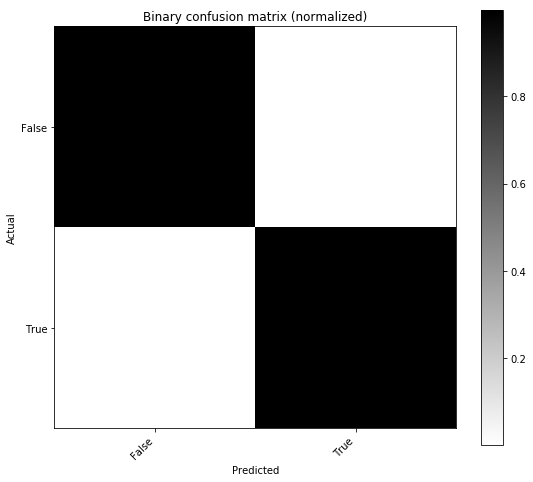

population: 187648
P: 93873
N: 93775
PositiveTest: 94039
NegativeTest: 93609
TP: 93706
TN: 93442
FP: 333
FN: 167
TPR: 0.9982210007137302
TNR: 0.9964489469474807
PPV: 0.9964589159816671
NPV: 0.9982159835058595
FPR: 0.003551053052519328
FDR: 0.0035410840183328195
FNR: 0.0017789992862697473
ACC: 0.9973354365620737
F1_score: 0.9973391800417216
MCC: 4.5493336405068865
informedness: 0.9946699476612109
markedness: 0.9946748994875265
prevalence: 0.5002611272169167
LRP: 281.1056286544446
LRN: 0.001785339120202324
DOR: 157452.23160885437
FOR: 0.0017840164941405206


In [16]:
# Plotting a confusion matrix
confusion_matrix3 = ConfusionMatrix(y3_correct, y3_predicted)
print("Confusion matrix: \n\n{}"  .format(confusion_matrix3))
confusion_matrix3.plot(normalized = True)
plt.show()
confusion_matrix3.print_stats()

Text(0.5,1,'2-class Precision-Recall curve: AP=1.00')

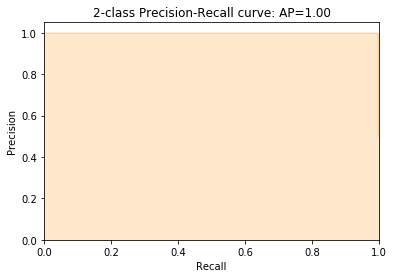

In [17]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision, recall, _ = precision_recall_curve(y3_correct, y3_predicted)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='darkorange', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='darkorange', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision3))

AUC: 1.00


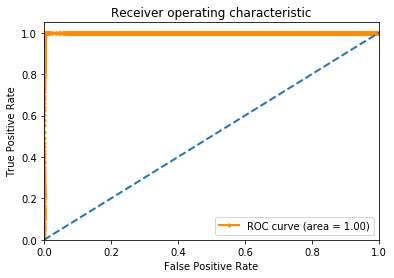

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
probs = model3.predict_proba(X3_test)

# calculate AUC
auc = roc_auc_score(y3_correct, probs)
print('AUC: {0:.2f}' .format(auc))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y3_correct, probs)

plt.figure()
lw = 2
# plot the roc curve for the model
plt.plot(fpr, tpr, color='darkorange', marker='.',
         lw=lw, label='ROC curve (area = {0:0.2f})' .format(auc))
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# show the plot
plt.show()